Connection length plots (Wendelstein 7-X)
================================

This example shows how to create connection-length plots for Wendelstein 7-X. First, we need to perform some setup to make sure W7-X data are available.

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x


In [2]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration.

In [3]:
field = w7x.standard()
geometry = w7x.op21Geometry()

grid = fsc.capnp.clone(w7x.defaultGrid)
grid.nR = 128
grid.nZ = 128
grid.nPhi = 32

Now, we need to define the points on which we want to calculate the connection length

In [11]:
import numpy as np
rRange = np.linspace(5.5, 6, 50)
zRange = np.linspace(-0.2, -0.15, 50)

rStart, zStart = np.meshgrid(rRange, zRange, indexing = 'ij')
phi = np.radians(200.8)

xStart = np.cos(phi) * rStart
yStart = np.sin(phi) * rStart
startPoints = [xStart, yStart, zStart]

Before running the calculation, I would like to show a little trick that is good for speedups. In the Poincare example, we passed the grids directly to the trace function, so that it compute fields and indexed geometries by itself. If we call trace repeatedly, this is inefficient. So this time, we will ahead of time request the computation and reference its result.

In [12]:
field = field.compute(grid)
geometry = geometry.index(w7x.defaultGeometryGrid)

Now it's time to run our calculation. Since we already computed field and geometry, the grids are no longer required. For connection length plots, we simply limit the number of collisions to 1 and inspect the field line length.

In [ ]:
conLength = fsc.flt.connectionLength(
    startPoints, field, geometry,
    distanceLimit = 1e4
)

The calculation returns a numpy array with a specific shape:
- The first dimension of the array is always 5. The first 3 entries are the x, y, z positions of the intersection points, while the other 2 are forward and backward connection-lengths. Negative values indicate, that the respective length (given by the absolute value) is given by something other than a collision event (start point, tracing limit, leaving the grid, etc.)
- The second dimension corresponds to the selected phi values to do the intersection at.
- The third dimension on corresponds to the dimensions of the starting point array (excluding its first xyz dimension)
- Finally, the last dimension corresponds to the turn counter of the field line.

In [7]:
# Shape is [5, nPlanes] + startsPoints.shape[1:] + [nTurns]
pcPoints.shape

(5, 6, 20, 5, 200)

We can now plot each series of intersection points. For this, we can also make use of the fsc.geometry.plotCut function, which will compute phi slices of the geometry.

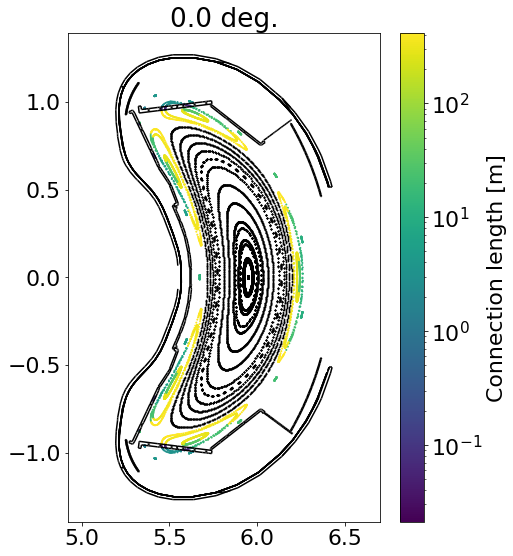

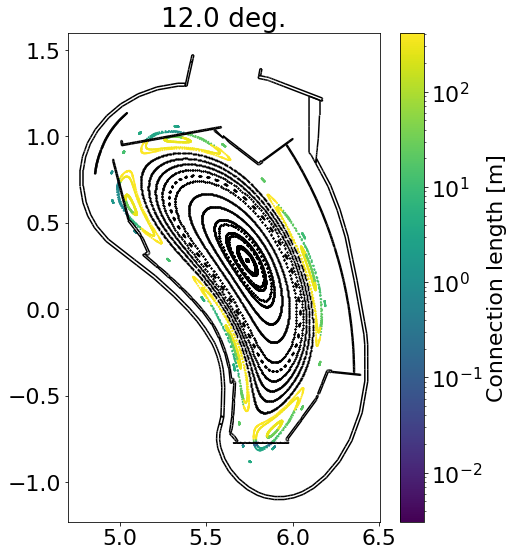

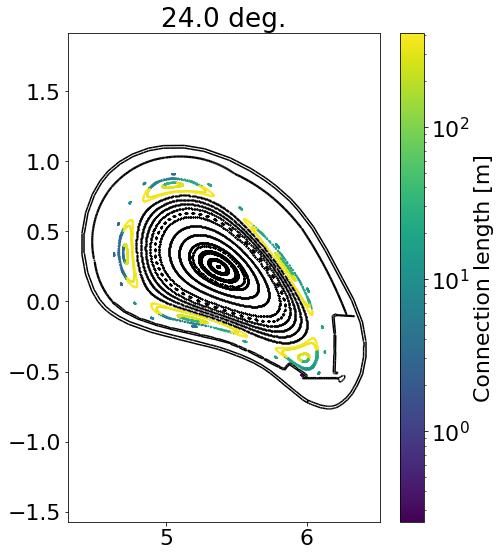

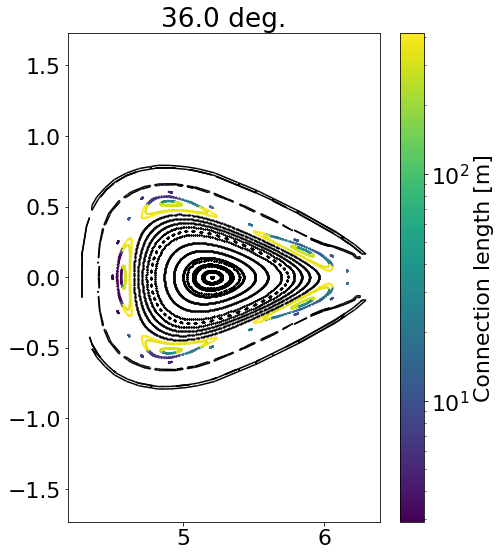

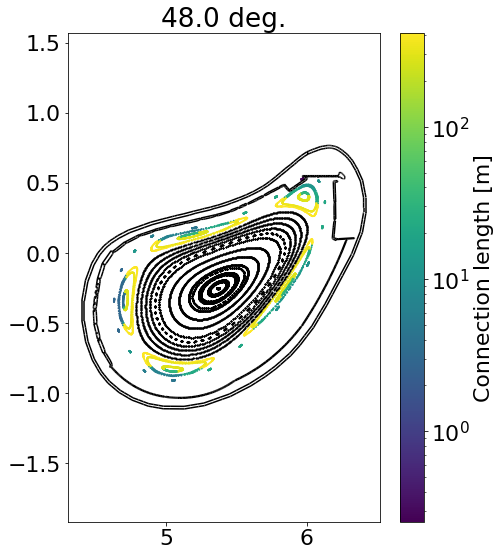

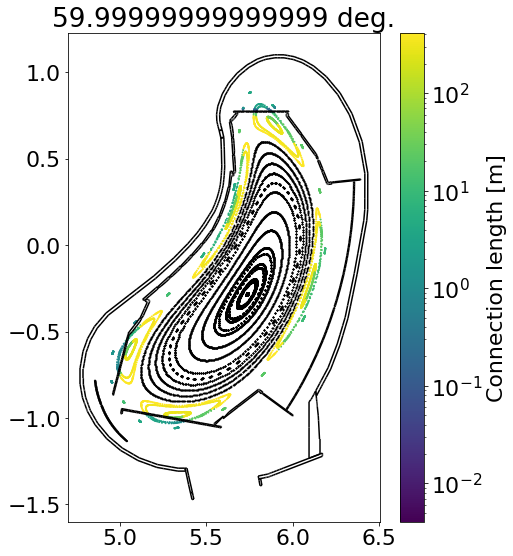

In [9]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 22})

for iPhi, phi in enumerate(phiPlanes):
    x, y, z, cLenF, cLenB = pcPoints[:, iPhi, :, :].reshape([5, -1])
    r = np.sqrt(x**2 + y**2)
    
    # Negative connection lengths indicate that the line segment going through
    # the point in that direction is not terminated by collision (e.g. it left
    # the grid or hit the distance limit)
    mask = np.logical_and(cLenF > 0, cLenB > 0)
    mask2 = np.logical_and(cLenF < 0, cLenB < 0)
    
    cLen = cLenF + cLenB
    
    plt.figure(figsize = (7, 9))
    plt.title(str(np.degrees(phi)) + ' deg.')
    plt.scatter(r[mask], z[mask], c = cLen[mask], norm = matplotlib.colors.LogNorm(), s = 1)
    plt.colorbar(label = 'Connection length [m]')
    plt.scatter(r[mask2], z[mask2], c = 'k', s = 0.5)
    
    geometry.plotCut(phi, edgecolors = 'k')
    plt.axis('equal')